In [1]:
# Import standard libraries
import os
from importlib import reload
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import pandas as pd
import pickle
import itertools
from itertools import groupby
import os.path
import math
import pybedtools
import time
from tqdm import tqdm
import random
import MOODS.parsers
import MOODS.tools
import MOODS.scan
import subprocess
# Custom libraries
import utils as lu
import process_jaspar_with_strand as pj
# Reload modules in case of modifications
reload(lu)
reload(pj)

/home/louiscam/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<module 'process_jaspar_with_strand' from '/home/louiscam/projects/gpcr/code/JASPAR_processing/process_jaspar_with_strand.py'>

# Directories

In [2]:
# Directory of adhesome data
dir_adhesome = '/home/louiscam/projects/gpcr/data/adhesome_data/'
# Directory of genome data
dir_genome = '/home/louiscam/projects/gpcr/data/genome_data/'
prom_hg19_seq_dir = dir_genome+'prom_hg19_seq_dir/'
# Directory of processed HiC
dir_processed_hic = '/home/louiscam/projects/gpcr/save/processed_hic_data_dir/'
# Directory for storing preliminary results
prelim_results_dir = '/home/louiscam/projects/gpcr/save/prelim_results_dir/'
# Directory of epigenomic data
epigenome_dir = '/home/louiscam/projects/gpcr/data/epigenome_data/'
processed_epigenome_data_dir = '/home/louiscam/projects/gpcr/save/processed_epigenome_data_dir/'
# Saving directory
saving_dir = '/home/louiscam/projects/gpcr/save/figures/'
# Directory of tf data
tf_dir = '/home/louiscam/projects/gpcr/data/tf_data/'
jaspar_dir = tf_dir+'jaspar_data/'
pfm_dir = tf_dir+'pfm_data/'
fantom5_dir = '/home/louiscam/projects/gpcr/data/fantom5/'
moods_out_dir = tf_dir+'moods_cage_outdir_with_strand/'
cage_fasta_dir = dir_genome+'cage_hg19_seq_dir_with_strand/'

# 1. Select genes of interest

### Load genes of interest (active adhesome genes)

In [3]:
# Genes of interest and location
selected_genes = pickle.load(open(saving_dir+'active_adhesome_genes.pkl', 'rb'))
print('Number of genes of interest = '+str(len(selected_genes)))

Number of genes of interest = 219


In [4]:
# Mapping UCSC to HGNC
ucsc_to_hgnc = pj.create_ucsc_hgnc_dict(dir_genome+'chrom_hg19.name')

### Load human TFs list
from http://humantfs.ccbr.utoronto.ca/

In [5]:
# Load TFs
tf_df = pd.read_csv(dir_genome+'human_tf.database', sep='\t', header=0, index_col=0)
tf_df = tf_df[tf_df['Is TF?']=='Yes'].sort_values(by=['HGNC symbol'])
all_tfs = tf_df['HGNC symbol'].values
print('Total number of TFs = '+str(len(all_tfs)))

Total number of TFs = 1639


### Gene location

In [127]:
# Load gene locations
gene_locations_filename = dir_genome+'chrom_hg19.loc'
df_loc = pd.read_csv(gene_locations_filename, sep = '\t', header = 0)
df_loc.columns = ['transcript','chrom','strand','txStart','txEnd','cdsStart','cdsEnd',
                  'exonCount','exonStarts','exonEnds','proteinID','alignID']
df_loc['gene'] = [ucsc_to_hgnc[t] for t in df_loc['transcript']]
# Pick largest extent of each gene
min_extent_gene = df_loc.groupby(['gene'], sort=False)['txStart'].min().rename('tx_minStart')
max_extent_gene = df_loc.groupby(['gene'], sort=False)['txEnd'].max().rename('tx_maxEnd')
df_loc = pd.merge(df_loc, min_extent_gene, on='gene')
df_loc = pd.merge(df_loc, max_extent_gene, on='gene')
df_loc = df_loc[['transcript','gene','chrom','strand',
                 'tx_minStart','tx_maxEnd']]
# Determine the strand of the gene (in case of labeling error)
df_loc = pd.merge(df_loc, 
                  df_loc.groupby(['gene','chrom','tx_minStart','tx_maxEnd'])['strand'].count().rename('strand_vote'),
                  on=['gene','chrom','tx_minStart','tx_maxEnd'])
df_loc = df_loc.sort_values(by=['gene','strand_vote'])
df_loc = df_loc.drop_duplicates(subset=['gene','chrom','tx_minStart','tx_maxEnd'], keep='first')
df_loc = df_loc[['gene','chrom','strand','tx_minStart','tx_maxEnd']]
df_loc.columns = ['gene','chrom','strand','txStart','txEnd']
# Only keep transcripts matching largest extent
df_loc.head()

,gene,chrom,strand,txStart,txEnd
817,5S_RRNA,chr18,-,327954,242524490
818,5S_RRNA,chr19,+,327954,242524490
823,5S_RRNA,chr21,+,327954,242524490
825,5S_RRNA,chr22,-,327954,242524490
793,5S_RRNA,chr12,+,327954,242524490


In [78]:
# Canonical transcript  for each gene
gene_id_filename = dir_genome+'chrom_hg19.name'
gene_locations_filename = dir_genome+'chrom_hg19.loc_canonical'
canonical_transcripts_df = lu.get_gene_locations(gene_locations_filename, gene_id_filename)
canonical_transcripts_df.columns = ['transcript','gene','chrom','start','end','clusterId','protein']
canonical_transcripts_df = canonical_transcripts_df[['transcript','gene']]

In [80]:
canonical_transcripts_df[canonical_transcripts_df['gene']=='PDPK1']

,transcript,gene
10708,uc002cqz.1,PDPK1


In [51]:
# Canonical gene location and metadata
gene_locations_filename = dir_genome+'chrom_hg19.loc'
df_loc = pd.read_csv(gene_locations_filename, sep = '\t', header = 0)
df_loc.columns = ['transcript','chrom','strand','txStart','txEnd','cdsStart','cdsEnd',
                  'exonCount','exonStarts','exonEnds','proteinID','alignID']
df_loc = pd.merge(canonical_transcripts_df, df_loc, how='inner', on=['transcript'])
df_loc['txLength'] = df_loc['txEnd']-df_loc['txStart']
df_loc['isTF'] = [gene in all_tfs for gene in df_loc['gene']]

In [52]:
# Restrict to genes of interest
df_loc = df_loc[df_loc['gene'].isin(selected_genes)]
df_loc.columns = ['transcript','gene','chrom','strand','txStart','txEnd','cdsStart','cdsEnd','exonCount',
                  'exonStarts','exonEnds','proteinID','alignID','txLength','isTF']
df_loc = df_loc[['transcript','gene','chrom','strand','txStart','txEnd','txLength','isTF']]

In [53]:
# Correct mistake at PDPK1
df_loc.at[df_loc[df_loc['gene']=='PDPK1'].index[0],'strand'] = '+'

In [75]:
gene_locations_filename = dir_genome+'chrom_hg19.loc'
df_loc = pd.read_csv(gene_locations_filename, sep = '\t', header = 0)
df_loc['gene'] = [ucsc_to_hgnc[name] for name in df_loc['#name']]
df_loc[df_loc['gene']=='PDPK1']

,#name,chrom,strand,txStart,txEnd,cdsStart,cdsEnd,exonCount,exonStarts,exonEnds,proteinID,alignID,gene
60757,uc010uwe.2,chr16,+,2587964,2612228,2588113,2611618,3,"2587964,2607703,2611480,","2588137,2607964,2612228,",B4DF26,uc010uwe.2,PDPK1
60759,uc002cqv.1,chr16,+,2606896,2634065,2607760,2633733,9,"2606896,2611480,2611771,2615553,2616356,262742...","2607964,2611523,2611909,2615698,2616454,262750...",Q6A1A2,uc002cqv.1,PDPK1
60761,uc002cqs.4,chr16,+,2587964,2653191,2588113,2647768,14,"2587964,2607703,2611480,2611771,2615553,261635...","2588137,2607964,2611523,2611909,2615698,261645...",O15530,uc002cqs.4,PDPK1
60762,uc010bsn.4,chr16,+,2587964,2653191,2588113,2647673,12,"2587964,2607703,2611480,2611771,2615553,261635...","2588137,2607964,2611523,2611909,2615698,261645...",H0Y4Z0,uc010bsn.4,PDPK1
60763,uc002cqt.4,chr16,+,2587964,2653191,2588113,2647768,11,"2587964,2607703,2611480,2627425,2631295,263160...","2588137,2607964,2611523,2627501,2631364,263170...",O15530-4,uc002cqt.4,PDPK1
60764,uc002cqu.4,chr16,+,2588164,2653191,2607760,2647768,14,"2588164,2607703,2611480,2611771,2615553,261635...","2588772,2607964,2611523,2611909,2615698,261645...",O15530,uc002cqu.4,PDPK1
60768,uc002cqz.1,chr16,-,2666121,2693297,2666453,2692433,9,"2666121,2668482,2668822,2672690,2683739,268449...","2666774,2668579,2668891,2672766,2683837,268464...",Q6A1A2,uc002cqz.1,PDPK1


adhesome gene lengths quartile = [ 21507.   49385.  114977.5]


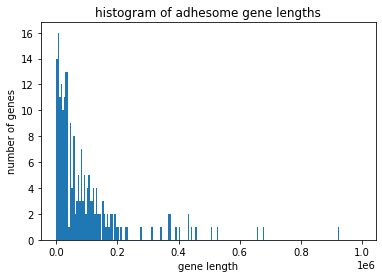

In [54]:
# Visualize distribution of gene lengths
print('adhesome gene lengths quartile = '+str(np.quantile(df_loc['txLength'].values, [0.25,0.5,0.75])))
plt.figure()
plt.hist(df_loc['txLength'], bins=np.arange(0,1000000,5000))
plt.xlabel('gene length')
plt.ylabel('number of genes')
plt.title('histogram of adhesome gene lengths')
plt.show()

### Define gene window

In [55]:
# Define region 1kb upstream of transcripts
df_loc['gene_window_start'] = [df_loc['txStart'].iloc[i]-1000 if (df_loc['strand'].iloc[i]=='+') 
                             else df_loc['txStart'].iloc[i] for i in range(df_loc.shape[0])]
df_loc['gene_window_end'] = [df_loc['txEnd'].iloc[i] if (df_loc['strand'].iloc[i]=='+') 
                             else df_loc['txEnd'].iloc[i]+1000 for i in range(df_loc.shape[0])]

In [56]:
# Visualize results
df_loc.head()

,transcript,gene,chrom,strand,txStart,txEnd,txLength,isTF,gene_window_start,gene_window_end
131,uc001isx.3,ABI1,chr10,-,27035524,27150016,114492,False,27035524,27151016
132,uc002uzz.3,ABI2,chr2,+,204193002,204296892,103890,False,204192002,204296892
133,uc002iop.1,ABI3,chr17,+,47287588,47300587,12999,False,47286588,47300587
135,uc004bzv.3,ABL1,chr9,+,133589267,133763062,173795,False,133588267,133763062
228,uc003sot.4,ACTB,chr7,-,5566778,5570232,3454,False,5566778,5571232


# 2. Select CAGE peaks

### Process robust CAGE peaks

In [57]:
# Load annotated FANTOM5 CAGE peaks
cage_df = pd.read_csv(fantom5_dir+'hg19.cage_peak_phase1and2combined_ann.txt', sep='\t', skiprows=7, header=0)
# Define new columns
cage_df['gene'] = cage_df['short_description'].str.split('@',expand=True)[1]
cage_df['chrom'] = cage_df['00Annotation'].str.split(':', expand=True)[0]
cage_df['cage_start'] = cage_df['00Annotation'].str.split(':', expand=True)[1].str.split(",", expand=True)[0].str.split(".", expand=True)[0].astype(int)
cage_df['cage_end'] = cage_df['00Annotation'].str.split(':', expand=True)[1].str.split(",", expand=True)[0].str.split(".", expand=True)[2].astype(int)
cage_df['strand'] = cage_df['00Annotation'].str.split(':', expand=True)[1].str.split(",", expand=True)[1]
cage_df['peak_id'] = cage_df['short_description'].str.split('@', expand=True)[0].str.strip('p')
# Reformat dataframe
cage_df = cage_df[['short_description', 'gene','association_with_transcript',
                   'chrom','cage_start','cage_end','strand','peak_id']]
cage_df = cage_df.sort_values(by=['chrom','cage_start'])
print('Number of unique CAGE peaks = '+str(len(np.unique(cage_df['short_description'].values))))
cage_df.head()

Number of unique CAGE peaks = 201802


,short_description,gene,association_with_transcript,chrom,cage_start,cage_end,strand,peak_id
95563,p1@MTND1P23,MTND1P23,129bp_to_ENST00000416931_5end,chr1,564571,564600,+,1
95564,p3@MTND1P23,MTND1P23,197bp_to_ENST00000416931_5end,chr1,564639,564649,+,3
95565,p3@MTND2P28,MTND2P28,246bp_to_ENST00000457540_5end,chr1,565266,565278,+,3
95566,p4@MTND2P28,MTND2P28,458bp_to_ENST00000457540_5end,chr1,565478,565483,+,4
95567,p1@MTND2P28,MTND2P28,489bp_to_ENST00000457540_5end,chr1,565509,565541,+,1


In [58]:
# Check which genes are located on the opposite strand of their promoter (mislabeling error)
# The only problematic error was on PDPK1, which has been taken care of before
merge_df = pd.merge(df_loc[['gene','strand']],cage_df[['gene','strand']], on=['gene'], suffixes=['_gene','_prom'])
merge_df[merge_df['strand_gene'] != merge_df['strand_prom']].drop_duplicates(subset=['gene'])

,gene,strand_gene,strand_prom
279,CALR,+,-


### CAGE peaks within selected gene windows

In [59]:
# Create bed file for regions upstream of genes of interest
gene_window_df = df_loc[['chrom','gene_window_start','gene_window_end','gene','strand']]
gene_window_df['score'] = 0
gene_window_df = gene_window_df[['chrom','gene_window_start','gene_window_end','gene','score','strand']]
gene_window_bed = pybedtools.BedTool.from_dataframe(gene_window_df).sort()

In [60]:
# Create a bed file for robust CAGE peaks
cage_peak_df = cage_df[['chrom','cage_start','cage_end','short_description','peak_id','strand']]
cage_bed = pybedtools.BedTool.from_dataframe(cage_peak_df).sort()

In [63]:
# Get CAGE peaks for each gene of interest
out = pybedtools.bedtool.BedTool.map(gene_window_bed, cage_bed, c=4, o='distinct', s=True)
out_df = out.to_dataframe()
out_df.columns=['chrom','gene_window_start','gene_window_end','gene','score','strand','peaks']
out_df = out_df[['chrom','gene_window_start','gene_window_end','gene','strand','peaks']]
out_df['peaks'] = out_df['peaks'].str.replace(',p',';p')

In [64]:
# Reformat matching results
peaks_per_gene_df = pd.merge(df_loc, out_df, on=['chrom','gene_window_start','gene_window_end','gene','strand'])
peaks_per_gene_df = peaks_per_gene_df[peaks_per_gene_df['peaks'] != '.']
peaks_per_gene_df['peaks'] = peaks_per_gene_df['peaks'].str.split(';')
peaks_per_gene_df['n_peaks'] = [len(peaks) for peaks in peaks_per_gene_df['peaks']]
peaks_per_gene_df
peaks_per_gene_df = peaks_per_gene_df[['gene', 'isTF', 'chrom', 'strand', 'txStart', 'txEnd', 'txLength',
                                       'gene_window_start', 'gene_window_end','peaks','n_peaks']]

In [65]:
# Visualize results
peaks_per_gene_df.head()

,gene,isTF,chrom,strand,txStart,txEnd,txLength,gene_window_start,gene_window_end,peaks,n_peaks
0,ABI1,False,chr10,-,27035524,27150016,114492,27035524,27151016,"[p1@ABI1, p2@ABI1, p3@ABI1, p4@ABI1, p@chr10:2...",10
1,ABI2,False,chr2,+,204193002,204296892,103890,204192002,204296892,"[p1@ABI2, p2@ABI2, p3@ABI2, p4@ABI2, p5@ABI2, ...",13
2,ABI3,False,chr17,+,47287588,47300587,12999,47286588,47300587,"[p1@ABI3, p2@ABI3, p3@ABI3, p4@ABI3, p5@ABI3, ...",9
3,ABL1,False,chr9,+,133589267,133763062,173795,133588267,133763062,"[p1@ABL1, p1@AF533988, p1@M14755, p2@ABL1, p3@...",14
4,ACTB,False,chr7,-,5566778,5570232,3454,5566778,5571232,"[p10@ACTB, p11@ACTB, p12@ACTB, p13@ACTB, p14@A...",28


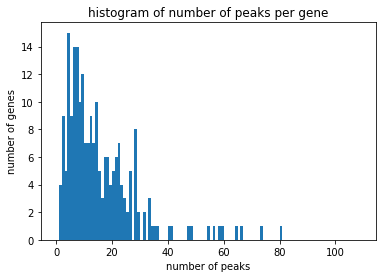

In [66]:
# Histogram of number of peaks per gene
plt.figure()
plt.hist(peaks_per_gene_df['n_peaks'], bins=np.arange(0,110,1))
plt.xlabel('number of peaks')
plt.ylabel('number of genes')
plt.title('histogram of number of peaks per gene')
plt.show()

In [67]:
peaks_per_gene_df[peaks_per_gene_df['gene']=='PDPK1']

,gene,isTF,chrom,strand,txStart,txEnd,txLength,gene_window_start,gene_window_end,peaks,n_peaks


# 3. Associate CAGE peaks with genes

In [19]:
# Dataframe of genes for each peak
genes_per_peak = peaks_per_gene_df[['gene','peaks']]
genes_per_peak = lu.unnesting(genes_per_peak,['peaks'])
genes_per_peak = genes_per_peak.groupby('peaks')['gene'].apply(list).reset_index(name='genes')
genes_per_peak['n_genes'] = [len(genes) for genes in genes_per_peak['genes']]
genes_per_peak.columns = ['short_description','genes','n_genes']

/home/louiscam/projects/gpcr/code/JASPAR_processing/utils.py:37: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  return df1.join(df.drop(explode, 1), how='left')


In [20]:
# Add peak location
genes_per_peak = pd.merge(genes_per_peak, cage_df, on=['short_description'])
genes_per_peak = genes_per_peak[['short_description','chrom','cage_start','cage_end','strand','genes']]
genes_per_peak = genes_per_peak.sort_values(by=['chrom'])

In [21]:
# Consider a window around each peak
genes_per_peak['cage_window_start'] = [genes_per_peak['cage_start'].iloc[i]-400 if (genes_per_peak['strand'].iloc[i]=='+') 
                                       else genes_per_peak['cage_start'].iloc[i]-50 for i in range(genes_per_peak.shape[0])]
genes_per_peak['cage_window_end'] = [genes_per_peak['cage_end'].iloc[i]+50 if (genes_per_peak['strand'].iloc[i]=='+') 
                                     else genes_per_peak['cage_end'].iloc[i]+400 for i in range(genes_per_peak.shape[0])]

In [22]:
# Visualize
genes_per_peak.head()

,short_description,chrom,cage_start,cage_end,strand,genes,cage_window_start,cage_window_end
1674,p7@SHC1,chr1,154943559,154943605,-,[SHC1],154943509,154944005
957,p31@NEXN,chr1,78383264,78383274,+,[NEXN],78382864,78383324
1247,p4@CAPN2,chr1,223900286,223900299,+,[CAPN2],223899886,223900349
1262,p4@ENAH,chr1,225742743,225742761,-,[ENAH],225742693,225743161
946,p30@ARHGEF2,chr1,155940369,155940382,-,[ARHGEF2],155940319,155940782


# 4. Create sequence files for all CAGE windows

# 5. Search for TFBS in all CAGE windows
See process_JASPAR_with_strand.py

# 6. Find TFs binding each CAGE window

### Useful data

In [23]:
# Load JASPAR TFBS metadata
jaspar_df = pd.read_csv(tf_dir+'JASPAR-HomoSapiens.csv', 
                        header=0, usecols=['ID','Name','Species','Class','Family'])
jaspar_tfs = np.unique(jaspar_df['Name'])
# Mapping JASPAR ID to HGNC
jasparid_to_hgnc = {jaspar_df.iloc[i,0]:jaspar_df.iloc[i,1] for i in range(jaspar_df.shape[0])}

In [24]:
# Visualize data
print('Number of unique TFs = '+str(len(np.unique(jaspar_df['Name']))))
print('Number of unique TF motifs = '+str(len(np.unique(jaspar_df['ID']))))
jaspar_df.head()

Number of unique TFs = 639
Number of unique TF motifs = 810


,ID,Name,Species,Class,Family
0,MA0002.1,RUNX1,Homo sapiens,Runt domain factors,Runt-related factors
1,MA0003.1,TFAP2A,Homo sapiens,Basic helix-span-helix factors (bHSH),AP-2
2,MA0003.2,TFAP2A,Homo sapiens,Basic helix-span-helix factors (bHSH),AP-2
3,MA0003.3,TFAP2A,Homo sapiens,Basic helix-span-helix factors (bHSH),AP-2
4,MA0003.4,TFAP2A,Homo sapiens,Basic helix-span-helix factors (bHSH),AP-2


### Load MOODS results

In [25]:
# Create dictionary mapping CAGE peaks to the corresponding TFs
tfs_associated_to_cage_peaks = {}

# 7. Find TFs targeting genes of interest

In [26]:
# Load mapping between cage peaks and corresponding TFs
tfs_associated_to_cage_peaks = pickle.load(open(saving_dir+'tfs_cage_with_strand.pkl', 'rb'))

In [27]:
# Construct dataframe with gene-tf pairs
tf_and_genes_df = genes_per_peak.copy()
tf_and_genes_df['tfs'] = [tfs_associated_to_cage_peaks[cage_peak] if cage_peak in tfs_associated_to_cage_peaks.keys()
                          else ['ToDo']
                          for cage_peak in tf_and_genes_df['short_description'].values]
tf_and_genes_df = lu.unnesting(tf_and_genes_df,['genes'])
gene_to_tfs = {tf_and_genes_df.iloc[i,0]:tf_and_genes_df.iloc[i,8] for i in range(tf_and_genes_df.shape[0])}
tf_and_genes_df = lu.unnesting(tf_and_genes_df,['tfs'])
tf_and_genes_df = tf_and_genes_df[['genes','tfs','short_description','chrom','cage_start','cage_end','strand']]
tf_and_genes_df = tf_and_genes_df.sort_values(by=['genes','tfs'])

/home/louiscam/projects/gpcr/code/JASPAR_processing/utils.py:37: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  return df1.join(df.drop(explode, 1), how='left')


In [28]:
# Visualize results
tf_and_genes_df.head()

,genes,tfs,short_description,chrom,cage_start,cage_end,strand
1019,ABI1,ALX3,p3@ABI1,chr10,27149904,27149920,-
1019,ABI1,ARGFX,p3@ABI1,chr10,27149904,27149920,-
1920,ABI1,BACH2,"p@chr10:27149068..27149079,-",chr10,27149068,27149079,-
1918,ABI1,E2F6,"p@chr10:27132379..27132382,-",chr10,27132379,27132382,-
1915,ABI1,EBF1,"p@chr10:27037479..27037487,-",chr10,27037479,27037487,-


In [30]:
# Save dictionary mapping selected genes to their potential TFs to pickle
pickle.dump(gene_to_tfs, open(saving_dir+'gene_to_tfs_with_strand.pkl', 'wb'))
gene_to_tfs

{'SHC1': array(['MEIS1', 'MEIS3', 'NFATC4', 'NR2F6(var.3)', 'PBX3', 'RARA(var.2)',
        'RARA::RXRA', 'RARA::RXRG'], dtype=object),
 'NEXN': array(['MAZ', 'NFATC4', 'POU3F3', 'ZNF140'], dtype=object),
 'CAPN2': array(['EWSR1-FLI1', 'NFIB', 'NFIC(var.2)', 'NFIC::TLX1', 'NFIX(var.2)',
        'SOX18', 'SPI1', 'ZNF16', 'ZNF354C'], dtype=object),
 'ENAH': array(['ALX3', 'ASCL1', 'BHLHA15(var.2)', 'IRF4', 'IRF8', 'LMX1A',
        'MIXL1', 'MYOG', 'NHLH1', 'NHLH2', 'PRDM1', 'SPIC', 'STAT3',
        'ZNF148', 'ZNF740'], dtype=object),
 'ARHGEF2': array(['BACH1', 'ETV4', 'FOSL2', 'MAF::NFE2', 'MAFK', 'NFATC2', 'NFE2L1',
        'TBR1'], dtype=object),
 'MACF1': array(['CTCF', 'PRDM1', 'SPI1'], dtype=object),
 'ITGB3BP': array(['EBF3', 'SPI1'], dtype=object),
 'VAV3': array(['BATF', 'BATF3', 'BATF::JUN', 'FOSL1::JUN', 'HOXA4', 'JUN(var.2)',
        'JUN::JUNB', 'NFATC2', 'RORA'], dtype=object),
 'BCAR3': array(['ELF1', 'ERF', 'ETV1', 'ETV4', 'FOS::JUND', 'HNF1A', 'HNF1B',
        'NFIC', 'ZN

In [34]:
moods_out_dir = tf_dir+'moods_cage_outdir_without_strand/'
peak_moods_file = os.listdir(moods_out_dir)[0]
print(peak_moods_file)

p@chr19:44259741..44259757,-.txt


In [33]:
pd.read_csv(moods_out_dir+peak_moods_file, sep=',', header=None, 
                         usecols=[0,1,2,3,4,5], 
                         names=['peak_id','tfbs_file','motif_loc','match_strand','match_score','motif'])

,peak_id,tfbs_file,motif_loc,match_strand,match_score,motif
0,chr17:80194610-80195090,MA0063.2.pfm,413,+,9.166249,GGCACTCAACT
1,chr17:80194610-80195090,MA0616.2.pfm,161,-,10.344406,CGCACGTGCC
2,chr17:80194610-80195090,MA0822.1.pfm,160,+,10.318423,CCGCACGTGCCA
3,chr17:80194610-80195090,MA0822.1.pfm,160,-,9.420233,CCGCACGTGCCA
4,chr17:80194610-80195090,MA1155.1.pfm,0,-,8.068437,TCTGCAGTGTGTGCG
5,chr17:80194610-80195090,MA1560.1.pfm,161,+,10.152223,CGCACGTGCC
6,chr17:80194610-80195090,MA1589.1.pfm,183,-,11.370343,GGCCGTGCACTTCTGCTCCTG
7,chr17:80194610-80195090,MA1594.1.pfm,372,+,2.384955,GGGGGCTCTCACCACATTCCCTTT
8,chr17:80194610-80195090,MA1645.1.pfm,411,+,7.856886,TTGGCACTCAACTT
